In [152]:
import polars as pl
import pandas as pd
from xgboost import XGBRegressor, XGBRFRegressor
import lightgbm as lgb
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pyecharts.charts import Line
from pyecharts import options as opts
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences
from utilsforecast.plotting import plot_series

today= datetime.now()

In [236]:
df=pl.read_parquet("C:\\Users\\smishra14\\OneDrive - Stryker\\data\\Endoscopy.parquet")
df=df[['CatalogNumber','SALES_DATE','`Act Orders Rev','`Fcst Stat Prelim Rev']]
df1=df.filter(pl.col('SALES_DATE')<today-relativedelta(months=1))
df1=df1.group_by(['CatalogNumber','SALES_DATE']).sum()
df1=df1.sort('SALES_DATE',descending=False)
cc=df.group_by('CatalogNumber').sum().sort('`Act Orders Rev',descending=True)

In [290]:
def preprocess1(df):
    df=df.with_columns(month=pl.col('SALES_DATE').dt.month())
    df=df.with_columns(days=(pl.col('SALES_DATE')-datetime(year=2021,month=1,day=1)).dt.total_days())
    return df

In [291]:
pp=preprocess1(df1)
#pp=pp.with_columns(pl.when(pl.col('lag3').is_null()).then(pl.col('`Act Orders Rev')).otherwise(pl.col('lag3')).alias('lag3'))
pp.filter(pl.col('CatalogNumber')=='CH00000001')

CatalogNumber,SALES_DATE,`Act Orders Rev,`Fcst Stat Prelim Rev,month,days
str,datetime[μs],f64,f64,i8,i64
"""CH00000001""",2021-10-01 00:00:00,0.0,0.0,10,273
"""CH00000001""",2021-11-01 00:00:00,242.0,0.0,11,304
"""CH00000001""",2021-12-01 00:00:00,124.0,0.0,12,334
"""CH00000001""",2022-01-01 00:00:00,210.0,0.0,1,365
"""CH00000001""",2022-02-01 00:00:00,182.0,0.0,2,396
…,…,…,…,…,…
"""CH00000001""",2024-10-01 00:00:00,99.0,0.0,10,1369
"""CH00000001""",2024-11-01 00:00:00,60.0,0.0,11,1400
"""CH00000001""",2024-12-01 00:00:00,6.0,0.0,12,1430


In [292]:
for i in cc['CatalogNumber'][:10]:
    mod=XGBRFRegressor()
    mod.fit(X=pp.filter(pl.col('CatalogNumber')==i).drop(['CatalogNumber','SALES_DATE','`Act Orders Rev','`Fcst Stat Prelim Rev']),y=pp.filter(pl.col('CatalogNumber')==i)['`Act Orders Rev'])
    mod.save_model(f'models/{i}.pkl')

c:\Users\smishra14\setup\miniconda\envs\fcst\Lib\site-packages\xgboost\core.py:158: UserWarning:

[18:02:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.



In [ ]:
fdf=pl.DataFrame({'SALES_DATE':pl.date_range(today.replace(day=1),today.replace(day=1)+relativedelta(months=60), "1mo",eager=True)})
fp=preprocess1(fdf)

SALES_DATE,month,days
date,i8,i64
2025-03-01,3,1520
2025-04-01,4,1551
2025-05-01,5,1581
2025-06-01,6,1612
2025-07-01,7,1642
…,…,…
2029-11-01,11,3226
2029-12-01,12,3256
2030-01-01,1,3287


In [325]:
plot(df1,pred,'2329')

In [296]:
pr=XGBRFRegressor()
pr.load_model(f'models/2329.pkl')
pred=pr.predict(fp[['month','days']])

In [324]:
def plot(df,pred,cat):
    pdf=df.filter(pl.col('CatalogNumber')==cat)
    prd=pl.DataFrame({'SALES_DATE':pl.date_range(today.replace(day=1),today.replace(day=1)+relativedelta(months=len(pred)-1), "1mo",eager=True),'XGBoost':pred})
    pdf=pdf.with_columns(pl.col('SALES_DATE').cast(pl.Date))
    pdf=pdf.join(prd,on='SALES_DATE', how="full", coalesce=True)
    pdf=pdf.sort('SALES_DATE',descending=False)
    line=Line()
    line.add_xaxis(pdf['SALES_DATE'].to_list()).add_yaxis('Act Orders',pdf['`Act Orders Rev'].to_list(),label_opts=opts.LabelOpts(is_show=False)) \
    .add_yaxis('XGBoost',pdf['XGBoost'].to_list(),label_opts=opts.LabelOpts(is_show=False))
    line.load_javascript()
    return line.render_notebook()

In [321]:
df=df1
cat='2329'
pdf=df.filter(pl.col('CatalogNumber')==cat)
prd=pl.DataFrame({'SALES_DATE':pl.date_range(today.replace(day=1),today.replace(day=1)+relativedelta(months=len(pred)-1), "1mo",eager=True),'XGBoost':pred})
pdf=pdf.with_columns(pl.col('SALES_DATE').cast(pl.Date))
pdf=pdf.join(prd,on='SALES_DATE', how="full", coalesce=True)
pdf=pdf.sort('SALES_DATE',descending=False)
line=Line()
line.add_xaxis(pdf['SALES_DATE'].to_list()).add_yaxis('Act Orders',pdf['`Act Orders Rev'].to_list(),label_opts=opts.LabelOpts(is_show=False)) \
.add_yaxis('XGBoost',pdf['XGBoost'].to_list(),label_opts=opts.LabelOpts(is_show=False))
line.load_javascript()
line.render_notebook()

In [ ]:
def preprocess(df):
    df=df.with_columns(lag3=pl.col('`Act Orders Rev').shift(3).over('CatalogNumber'))
    df=df.with_columns(pl.when(pl.col('lag3').is_null()).then(pl.col('`Act Orders Rev')).otherwise(pl.col('lag3')).alias('lag3'))
    df=df.with_columns(lag4=pl.col('`Act Orders Rev').shift(4).over('CatalogNumber'))
    df=df.with_columns(pl.when(pl.col('lag4').is_null()).then(pl.col('`Act Orders Rev')).otherwise(pl.col('lag4')).alias('lag4'))
    df=df.with_columns(lag5=pl.col('`Act Orders Rev').shift(5).over('CatalogNumber'))
    df=df.with_columns(pl.when(pl.col('lag5').is_null()).then(pl.col('`Act Orders Rev')).otherwise(pl.col('lag5')).alias('lag5'))
    df=df.with_columns(lag6=pl.col('`Act Orders Rev').shift(6).over('CatalogNumber'))
    df=df.with_columns(pl.when(pl.col('lag6').is_null()).then(pl.col('`Act Orders Rev')).otherwise(pl.col('lag6')).alias('lag6'))
    df=df.with_columns(lag12=pl.col('`Act Orders Rev').shift(12).over('CatalogNumber'))
    df=df.with_columns(pl.when(pl.col('lag12').is_null()).then(pl.col('`Act Orders Rev')).otherwise(pl.col('lag12')).alias('lag12'))
    df=df.with_columns(month=pl.col('SALES_DATE').dt.month())
    return df

In [ ]:
df=pd.read_parquet("C:\\Users\\smishra14\\OneDrive - Stryker\\data\\Endoscopy.parquet")
df=df[['CatalogNumber','SALES_DATE','`Act Orders Rev','`Fcst Stat Prelim Rev']]
df1=df[df['SALES_DATE']<today-relativedelta(months=1)]
df1=df1.groupby(['CatalogNumber','SALES_DATE']).sum().reset_index()
cc=df.groupby('CatalogNumber').sum(numeric_only=True)['`Act Orders Rev'].sort_values(ascending=False).reset_index()

In [174]:
fdf=df1.rename(columns={'SALES_DATE':'ds','CatalogNumber':'unique_id','`Act Orders Rev':'y'})
fdf=fdf.groupby(['unique_id','ds']).sum().reset_index()
for i in cc['CatalogNumber'][:10]:
    pdf=fdf[fdf['unique_id']==i]
    pdf=pdf[['unique_id','ds','y']]
    pdf=pdf[pdf['ds']<today-relativedelta(months=6)]
    pdf=pdf.dropna()
    fcst = MLForecast(models=[XGBRFRegressor()],freq='MS',lags=[3,4,5,6,12],)
    fcst.fit(pdf,static_features=[])
    fcst.save(f'models/{i}')

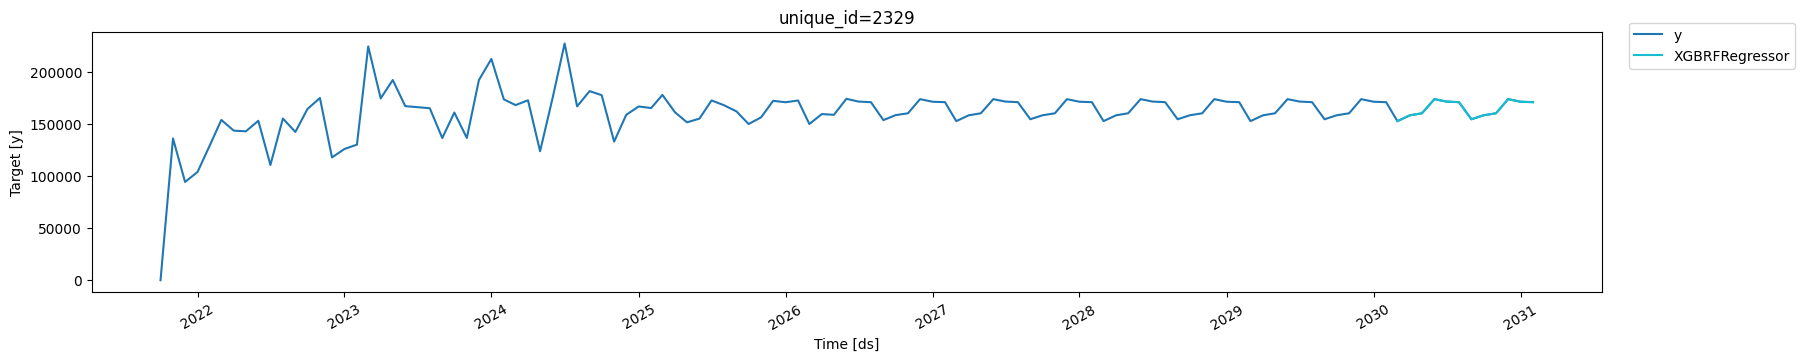

In [175]:
ff=MLForecast.load('models/2329')
tdf=fdf.groupby(['unique_id','ds']).sum().reset_index()
pdf=tdf[tdf['unique_id']=='2329']
pdf=pdf[['unique_id','ds','y']]
for i in range(6):
    pdf=pdf.dropna()
    prep=fcst.preprocess(pdf,static_features=[])
    preds=ff.predict(12,new_df=pdf)
    pdf=pd.concat([pdf,preds.rename(columns={'XGBRFRegressor':'y'})])
plot_series(pdf,preds,ids=['2329'])

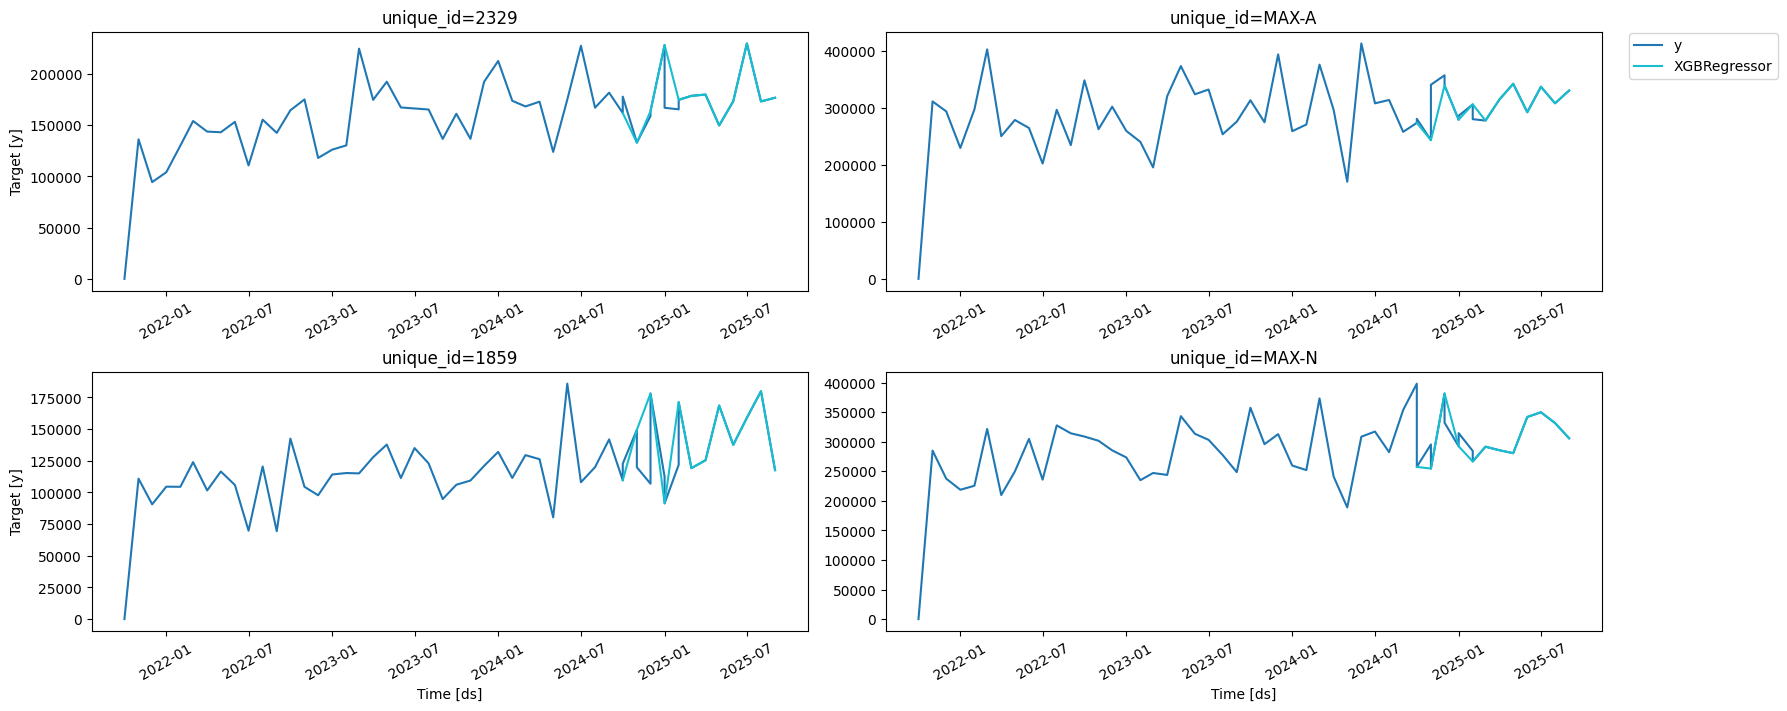

In [108]:
fdf=df1[df1['CatalogNumber'].isin(cc['CatalogNumber'][:20])]
fdf=fdf.rename(columns={'SALES_DATE':'ds','CatalogNumber':'unique_id','`Act Orders Rev':'y'})
tdf=fdf.rename(columns={'SALES_DATE':'ds','CatalogNumber':'unique_id','`Act Orders Rev':'y'})
tdf=tdf[['ds','unique_id','y']]
fdf=fdf.groupby(['unique_id','ds']).sum().reset_index()
tdf=tdf.groupby(['unique_id','ds']).sum().reset_index()
pdf=tdf[tdf['ds']<today-relativedelta(months=6)]

#preds=fcst.predict(60)
#for i in range(6):
tdf=tdf.fillna(0)
fcst = MLForecast(models=[XGBRegressor()],freq='MS',lags=[3,4,5,6,12,24],)
fcst.fit(pdf)
#prep=fcst.preprocess(tdf,static_features=[])
preds=fcst.predict(12)
tdf=pd.concat([tdf,preds.rename(columns={'XGBRegressor':'y'})])
plot_series(tdf, preds,ids=['2329','MAX-A','1859','MAX-N'])

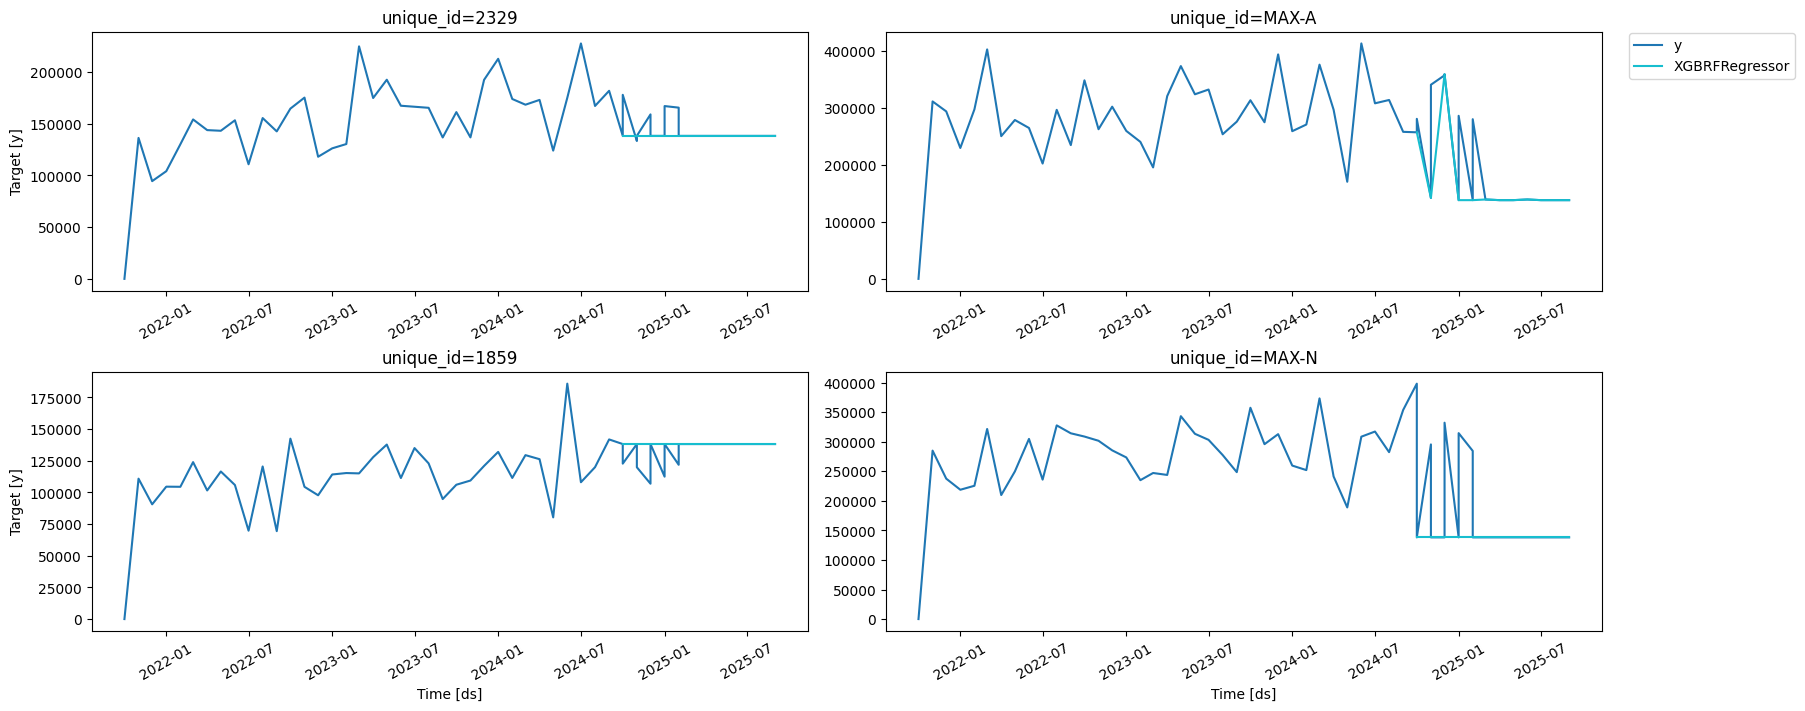

In [ ]:
plot_series(tdf, preds,ids=['2329','MAX-A','1859','MAX-N'])

In [ ]:
fcst.save('models/')

In [ ]:
line=Line()
line.add_xaxis(fdf['SALES_DATE'].to_list()).add_yaxis('Act Orders',fdf['`Act Orders Rev'].to_list(),label_opts=opts.LabelOpts(is_show=False))
line.load_javascript()
line.render_notebook()